Описание данных

train.csv - данные для обучения

test.csv - данные для подготовки самбита и проверки

sampleSubmission.csv - пример корректного но бесполезного сабмита

other.csv - необязательные данные для доп.статистик и прочих извращений (например обучение word2vec-а)

Описание полей

id - внутренний идетификатор

name - название вакансии

description - текст вакансии

target - класс заинтересованности

#### Импортируем библиотеки

In [184]:
import pandas as pd  #Pandas
from bs4 import BeautifulSoup  #Синтактический разбор
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [185]:
#Импорт метрик
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

In [186]:
%matplotlib inline
from matplotlib import pyplot as plt

#### Импортируем данные

In [187]:
df = pd.read_csv('train.csv', sep='\t')

#### Анализируем данные

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
id             200000 non-null int64
name           200000 non-null object
description    200000 non-null object
target         200000 non-null int64
dtypes: int64(2), object(2)
memory usage: 6.1+ MB


In [189]:
df.head()

,id,name,description,target
0,0,Заведующий отделом/секцией в магазин YORK (Уру...,<p><strong>В НОВЫЙ МАГАЗИН YORK (хозтовары) пр...,1
1,1,Наладчик станков и манипуляторов с ПУ,Обязанности:работа на токарных станках с ЧПУ T...,0
2,2,Разработчик С++ (Криптограф),<strong>Требования:</strong> <ul> <li>Опыт про...,0
3,3,Фрезеровщик,<p>Условия:</p> <ul> <li>На работу вахтовым ме...,0
4,4,Мерчендайзер/продавец-консультант,<p><strong>Компания Палладиум Стандарт - призн...,1


#### Преобразовываем данные

#### Создаем столбец с объединеным текстом

In [190]:
df['alltext'] = df['name'] + ' ' + df['description']

In [191]:
#Число строк из основного DataFrame на которых проводим  выбор модели
cnt = 1000

In [192]:
def out_tag (df_in):
    #Лист данных без тэгов
    df_out = []
    #Цикл по DataFrame description b name
    for t in df_in['alltext'][:cnt]:
        #Добавление в лист ткстов без тегов
        df_out.append(
            BeautifulSoup(t, 'lxml').text
        )
    return df_out

In [193]:
df_x = out_tag(df)

In [194]:
df_y = df['target'][:cnt]

In [195]:
pd.DataFrame(df_x).shape

(1000, 1)

In [196]:
df_y.shape

(1000,)

#### Лематизация

In [197]:
#Модуль для работы с регулярными выражениями
import re

In [198]:
#Морфологический анализатор MyStemp
import pymystem3
#Инициализируем морфрологический анализатор
mystem = pymystem3.Mystem()

In [199]:
#Морфологический анализатор PyMorphy2
import pymorphy2
m2 = pymorphy2.MorphAnalyzer()

In [200]:
def my_tokenizer_ms(text):
    lemms = mystem.lemmatize(text)
    return [x for x in lemms if re.match('^[а-яё]+$', x)]  #match ищет по заданному шаблону в начале строки Если находит,
                                                            #то возвращет строку

In [201]:
#def my_tokenizer_pm2(text):
#    return [m2.normal_forms(x)[0] for x in text.split()]

In [202]:
def my_tokenizer_pm2(text):
    reswords = []
    words=[a[0] for a in re.findall("([А-ЯЁа-яё]+(-[А-ЯЁа-яё]+)*)", text)]
    for w in words:
        wordform=m2.parse(w)[0]
        if wordform.tag.POS in ['ADJF', 'NOUN', 'VERB']:
            reswords.append(wordform.normal_form)
    return reswords


In [203]:
my_tokenizer_ms(df_x[0])

['заведующий',
 'отдел',
 'секция',
 'в',
 'магазин',
 'уручье',
 'в',
 'новый',
 'магазин',
 'хозтовары',
 'приглашать',
 'на',
 'постоянный',
 'работа',
 'руководитель',
 'секция',
 'хозтовары',
 'обязанность',
 'организация',
 'эффективный',
 'и',
 'культурный',
 'обслуживание',
 'покупатель',
 'организация',
 'приемка',
 'сдача',
 'товар',
 'на',
 'склад',
 'консультация',
 'покупатель',
 'по',
 'вопрос',
 'касаться',
 'оказывать',
 'услуга',
 'контроль',
 'своевременный',
 'подача',
 'товар',
 'в',
 'торговый',
 'секция',
 'проверка',
 'качество',
 'срок',
 'годность',
 'наличие',
 'маркировка',
 'ценник',
 'на',
 'товар',
 'организация',
 'бесперебойный',
 'работа',
 'товарный',
 'секция',
 'и',
 'участок',
 'склад',
 'закреплять',
 'за',
 'она',
 'контроль',
 'за',
 'сохранность',
 'товар',
 'торговый',
 'оборудование',
 'и',
 'прочий',
 'материальный',
 'ценность',
 'инвентаризация',
 'товар',
 'требование',
 'знание',
 'товарный',
 'группа',
 'знание',
 'правило',
 'приемка',


In [204]:
my_tokenizer_pm2(df_x[0])

['отдел',
 'секция',
 'магазин',
 'уручей',
 'новый',
 'магазин',
 'хозтовары',
 'приглашать',
 'постоянный',
 'работа',
 'руководитель',
 'секция',
 'хозтовары',
 'обязанность',
 'организация',
 'эффективный',
 'культурный',
 'обслуживание',
 'покупатель',
 'организация',
 'приёмка-сдача',
 'товар',
 'склад',
 'консультация',
 'покупатель',
 'вопрос',
 'услуга',
 'контроль',
 'своевременный',
 'подача',
 'товар',
 'торговый',
 'секция',
 'проверка',
 'качество',
 'срок',
 'годность',
 'наличие',
 'маркировка',
 'ценник',
 'товар',
 'организация',
 'бесперебойный',
 'работа',
 'товарный',
 'секция',
 'участок',
 'склад',
 'контроль',
 'сохранность',
 'товар',
 'торговый',
 'оборудование',
 'прочий',
 'материальный',
 'ценность',
 'инвентаризация',
 'товар',
 'требование',
 'знание',
 'товарный',
 'группа',
 'знание',
 'правило',
 'приёмка',
 'товар',
 'опыт',
 'работа',
 'розничный',
 'торговля',
 'качество',
 'продавец',
 'заместитель',
 'секция',
 'отдел',
 'ответственность',
 'лидер

#### CountVectorizer

In [205]:
#Инициализация CountVectorizer
cv = CountVectorizer(tokenizer=my_tokenizer_pm2) #В параметрах написанная нами функция токенизатор

In [206]:
m = cv.fit_transform(df_x)

In [207]:
df_cv = pd.DataFrame(
    m.toarray(),
    columns=[x[0] for x in sorted(cv.vocabulary_.items(), key=lambda x: x[1])]
)
df_cv.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6828 columns):
а-класс                                                           1000 non-null int64
аббревиатура                                                      1000 non-null int64
абзац                                                             1000 non-null int64
абитуриент                                                        1000 non-null int64
або                                                               1000 non-null int64
абонемент                                                         1000 non-null int64
абонент                                                           1000 non-null int64
абонентский                                                       1000 non-null int64
абразивный                                                        1000 non-null int64
аванпроект                                                        1000 non-null int64
аванс                           

### Анализ моделей обучения

##### Подготовка данных для обучения

In [208]:
#Импорт библиотеки разделения данных
from sklearn.model_selection import train_test_split

In [209]:
#В качестве набора данных с фичами передаем набор прошедший CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(df_cv, df_y, test_size=0.33, random_state=42)

### RandomForestClassifier

In [210]:
from sklearn.ensemble import RandomForestClassifier

##### Цикл по глубине дерева

In [211]:
df_rfc_depth = pd.DataFrame(columns = ['DEPTH', 'ROC_AUC']);
for rfc_depth in range(1, 40):
    rfc = RandomForestClassifier(max_depth= rfc_depth )
    rfc.fit(X_train, y_train)        
    df_rfc_depth = df_rfc_depth.append({'DEPTH' : rfc_depth, 'ROC_AUC' : roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1])} , ignore_index=True)

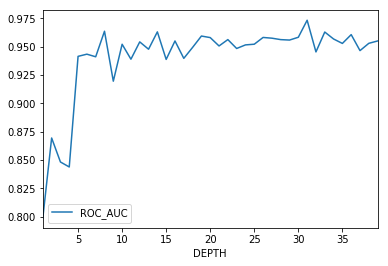

In [212]:
df_rfc_depth.plot(x='DEPTH', y= 'ROC_AUC')

### DecisionTreeClassifier

In [213]:
from sklearn.tree import DecisionTreeClassifier

In [214]:
#Инициализация дерева приниятия решения с глубиной 5
dtc = DecisionTreeClassifier(max_depth=1)
#Обучение
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [215]:
#Расчет ROC_AUC
roc_auc_score(y_test, dtc.predict_proba(X_test)[:,1])

0.82788832788832789

##### Цикл по глубине дерева

In [216]:
df_dtc_depth = pd.DataFrame(columns = ['DEPTH', 'ROC_AUC']);
for dtc_depth in range(1, 40):
    dtc = DecisionTreeClassifier(max_depth= dtc_depth )
    dtc.fit(X_train, y_train)        
    df_dtc_depth = df_dtc_depth.append({'DEPTH' : dtc_depth, 'ROC_AUC' : roc_auc_score(y_test, dtc.predict_proba(X_test)[:,1])} , ignore_index=True)

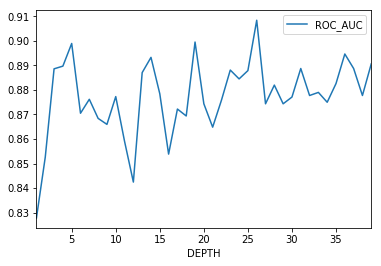

In [217]:
df_dtc_depth.plot(x='DEPTH', y= 'ROC_AUC')

### LogisticRegression

In [218]:
from sklearn.linear_model import LogisticRegression

#### Цикл по С

In [219]:
df_lr_c = pd.DataFrame(columns = ['C', 'L1_ROC_AUC', 'L2_ROC_AUC']);
for lr_c in [0.01, 0.1, 0.5, 0.8, 1, 1.2, 2, 10, 20,100]:
    lr = LogisticRegression(penalty='l1', C=lr_c)
    lr.fit(X_train, y_train) 
    lr_l1_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]);
    lr = LogisticRegression(penalty='l2', C=lr_c)
    lr.fit(X_train, y_train) 
    df_lr_c = df_lr_c.append({'C' : lr_c, 'L1_ROC_AUC' : lr_l1_auc, 'L2_ROC_AUC' : roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])} , ignore_index=True)

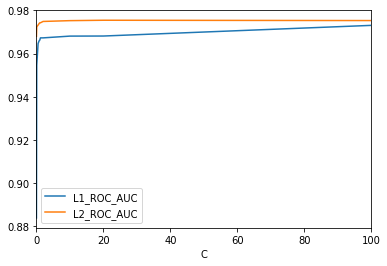

In [220]:
df_lr_c.plot(x='C', y= ['L1_ROC_AUC', 'L2_ROC_AUC'])

In [221]:
df_lr_c

,C,L1_ROC_AUC,L2_ROC_AUC
0,0.01,0.883873,0.968035
1,0.10,0.954670,0.972379
2,0.50,0.964694,0.973233
3,0.80,0.965882,0.973901
4,1.00,0.966253,0.974272
5,1.20,0.967293,0.974272
6,2.00,0.967293,0.974903
7,10.00,0.968110,0.975275
8,20.00,0.968147,0.975460
9,100.00,0.973084,0.975312


#### Разовый подсчет

In [222]:
lr = LogisticRegression(penalty='l2', C=20)
lr.fit(X_train, y_train)

LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [223]:
predict = lr.predict_proba(X_test)

In [224]:
roc_auc_score(y_test, predict[:,1])

0.9754603504603504

In [225]:
precision, recall, thresholds = precision_recall_curve(
y_test, predict[:,1])

(-0.01, 1.01)

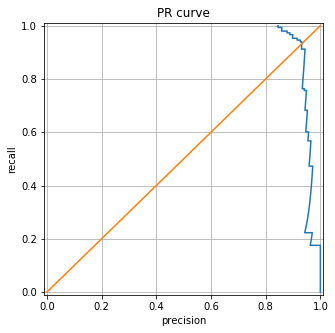

In [226]:
plt.figure(figsize=(5, 5))
plt.plot(precision, recall)
plt.plot([0, 1], [0, 1])
plt.ylabel('recall')
plt.xlabel('precision')
plt.grid(True)
plt.title('PR curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

(-0.01, 1.01)

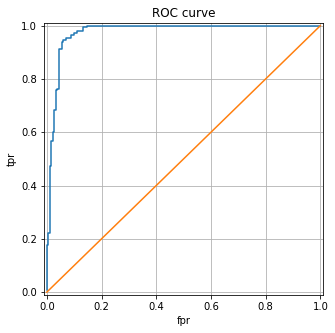

In [227]:
fpr, tpr, thresholds = roc_curve(y_test, predict[:,1]) 
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

### KNeighborsClassifier

In [228]:
from sklearn.neighbors import KNeighborsClassifier

#### Разовый расчет

In [229]:
knn = KNeighborsClassifier(n_neighbors= 2)
knn.fit(X_train, y_train)    

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [230]:
roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])

0.85951885951885965

#### Цикл по количеству соседей

In [231]:
df_knc_neighbors = pd.DataFrame(columns = ['NEIGHBORS', 'ROC_AUC']);
for knc_neighbors in [1,5,15,25,35,50, 100]:
    knn = KNeighborsClassifier(n_neighbors= knc_neighbors)
    knn.fit(X_train, y_train)        
    df_knc_neighbors = df_knc_neighbors.append({'NEIGHBORS' : knc_neighbors, 'ROC_AUC' : roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])} , ignore_index=True)

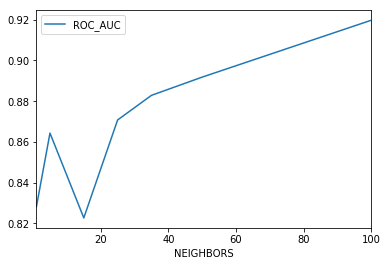

In [232]:
df_knc_neighbors.plot(x='NEIGHBORS', y= 'ROC_AUC')

### Cross Validation по LogisticRegression

In [233]:
from sklearn.cross_validation import cross_val_score

In [234]:
lr_cv = LogisticRegression(penalty='l2', C=20)
cross_val_score(
    lr_cv,
    df_cv,
    df_y,
    scoring='roc_auc',
    cv=10   #Количество частей
)

array([ 0.92553191,  0.97438928,  0.97123719,  0.96611505,  0.97109595,
        0.9955841 ,  0.98441345,  0.96923708,  0.97538966,  0.98933552])

## PipeLine

In [235]:
from sklearn.pipeline import Pipeline

In [236]:
model = Pipeline([
    ('vect', CountVectorizer(tokenizer=my_tokenizer_pm2)),  
    ('tfidf', TfidfTransformer(norm=None, smooth_idf=False)),
    ('lr', LogisticRegression(penalty='l2', C=20)),
])

#### Проверка модели по CrossValidation

In [237]:
#Проверка Cross Validation по модели
cross_val_score(
    model,
    df_x,
    df_y,
    scoring='roc_auc',
    cv=10   #Количество частей
)

array([ 0.93617021,  0.98108747,  0.97360126,  0.97123719,  0.9662786 ,
        0.99156965,  0.97949139,  0.97210829,  0.9659557 ,  0.99507793])

# Запуск на полных данных по выбранной модели

### Подготовка тренировочных данных

In [238]:
#Загрузка данных
df = pd.read_csv('train.csv', sep='\t')

In [239]:
#Создаем общее поле текста, объединяя название вакансии и описание
df['alltext'] = df['name'] + ' ' + df['description']
#Очищаем общее поле текста от тегов
df['alltext'] = df['alltext'].apply(lambda x: BeautifulSoup(x, 'lxml').text)
#Выделяем DataFrame с целевым показателем
df_y = df['target']
#Выделяем DataFrame с фичей в виде общего текста
df_x = df['alltext']

In [103]:
#Создание тренировочный и тестовых DataFrame
#X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.33, random_state=42)

In [240]:
#Обучение модели
#model.fit(X_train, y_train)
model.fit(df_x, df_y)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [241]:
#Анализ ROC_AUC
#roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

### Подготовка данных для Kaggle

In [242]:
#Загрузка данных для подготовки submission
df_test = pd.read_csv('test.csv', sep='\t')

In [243]:
#Создаем общее поле текста, объединяя название вакансии и описание
df_test['alltext'] = df_test['name'] + ' ' + df_test['description']
#Очищаем общее поле текста от тегов
df_test['alltext'] = df_test['alltext'].apply(lambda x: BeautifulSoup(x, 'lxml').text)
#Создаем DataFrame для predict
df_x_test = df_test['alltext']

In [244]:
#Предсказание на обученной модели по данным для submission
predict = model.predict(df_x_test)

In [245]:
#Результат предсказания чохранянм в DataFrame
df_pred = pd.DataFrame(predict)

In [246]:
#Результат предсказания cохранянм в CVS
df_pred.to_csv('pred.csv', sep='\t')

In [281]:
df_test['target'] = predict

In [282]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170179 entries, 0 to 170178
Data columns (total 6 columns):
id             170179 non-null int64
name           170179 non-null object
description    170179 non-null object
alltext        170179 non-null object
predict        170179 non-null int64
target         170179 non-null int64
dtypes: int64(3), object(3)
memory usage: 7.8+ MB


In [283]:
df_submis = df_test[['id', 'target']]

In [284]:
df_submis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170179 entries, 0 to 170178
Data columns (total 2 columns):
id        170179 non-null int64
target    170179 non-null int64
dtypes: int64(2)
memory usage: 2.6 MB


In [285]:
df_submis.to_csv('Submission.csv', sep=',', index=False)